# Exploring the sHDP

This notebook contains some of the experiments of the sHDP implementation by [Ardavans](https://github.com/Ardavans).

**Author:** Eemeli Saari

**Created:** 10.3.2019

**Edited:** 17.3.2019

---

In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append('../detector/sHDP')
sys.path.append('../detector/')

Here we're trying to cipher the functionality of the [sHDP](https://github.com/Ardavans/sHDP) Python code

In [5]:
from HDP import models
from corpora import Corpora
from fetcher.nips_fetcher import NIPSFetcher

In [6]:
data_path = '../data/parsed/'

In [7]:
tokens = [t for t, N in Corpora(data_path, parsing='simple').build().tokenize()]

In [8]:
N_DOCS = len(tokens)

In [9]:
N_DOCS

152

Model takes in some von Mises-Fisher components that need to be initialized.

In [10]:
from core.core_distributions import vonMisesFisherLogNormal

In [11]:
np.random.seed(42)
num_dim = 50
K = 40

d = np.random.rand(num_dim,)
d = d/np.linalg.norm(d)
obs_hypparams = dict(mu_0=d,C_0=1,m_0=2,sigma_0=0.25)
%time components=[vonMisesFisherLogNormal(**obs_hypparams) for itr in range(K)]

C:\Users\eemsaa\Documents\GitHub\KeyTopicDetection\detector\sHDP\core\util\stats.py:152: UserWarning: Not sure about sampling vMF, use with caution!!!! 
  warn('Not sure about sampling vMF, use with caution!!!! ')


Wall time: 847 ms


The von Mishes-Fisher initializer causes modern numpy to error so need change

sHDP/core/core_distributions.py
```python
241         if (mu,kappa) == (None,None) and None not in (mu_0.any(),C_0,m_0,sigma_0):
```

Also some parameters are tuned here.

In [12]:
hdp = models.HDP(alpha=1, gamma=2, obs_distns=components, num_docs=N_DOCS+1)

The data how ever that is fed up to the model is in pickled format which causes two issues:

1. You should not open any 3rd party pickle files on your computer.
2. The environment might cause some issues.

But since I'll need to find out what the data looks like:

In [13]:
import pickle

In [14]:
with open('../detector/sHDP/data/nips/texts.pk', 'rb') as f:
    texts = pickle.load(f)

UnpicklingError: the STRING opcode argument must be quoted

And it seems that the problem is the 2nd one meaning that the pickle was made in Ubuntu.

> Using VM Ubuntu 18.04 I was able to open the content.

The texts.pk and wordvec.pk content is easily understandable BOW format of the given text document and word vector dictionary.

## Tokens2bow

In [15]:
from gensim.corpora.dictionary import Dictionary

In [16]:
dictionary = Dictionary(tokens)

In [32]:
bow = [dictionary.doc2bow(d) for d in tokens]

## Word embeddings

In [18]:
from gensim.models.word2vec import Word2Vec

> **NOTE:** The size should match the num_dim parameter with sHDP

In [19]:
%time embedding_model = Word2Vec(tokens, size=50, window=5, min_count=1, workers=4)

Wall time: 2.31 s


In [20]:
embedding_model.vector_size

50

In [21]:
%time embedding_model.train(tokens, epochs=100, total_examples=len(tokens),)

Wall time: 32.7 s


(21705993, 22110900)

The authors of sHDP reported that they used normalized word vectors to train the model.

In [22]:
embeddings = np.empty((len(embedding_model.wv.vocab), 50))

In [23]:
embeddings.shape

(17885, 50)

In [24]:
len(dictionary)

17885

In [25]:
dictionary[0]

'ability'

In [26]:
for i in range(embeddings.shape[0]):
    assert dictionary[i] in embedding_model.wv.vocab
    embeddings[i, :] = embedding_model.wv[dictionary.id2token[i]]

In [27]:
from sklearn.preprocessing import normalize

In [28]:
normalized = normalize(embeddings, norm='l2', axis=1)

In [29]:
vectors_dict = {i:normalized[i, :] for i in range(embeddings.shape[0])}

The authors introduced these two functions to glovize the date

In [30]:
def glovize_data_wo_count(list_of_texts):
    all_data = []
    all_avail_words = []
    for text in list_of_texts:
        temp_list = []
        temp_list_words = []
        for word in text:
            try:
                temp_list.append((np.array(vectors_dict[word[0]]), word[1]))
                temp_list_words.append(word[0])
            except:
                pass
        all_data.append(np.array(temp_list))
        all_avail_words.append(np.array(temp_list_words))
    return all_data, all_avail_words

That both basically convert the bag-of-words word reprsentation to vector-of-words representation of numpy arrays for each document.

In [33]:
temp2, temp_words = glovize_data_wo_count(bow)

But they both essentially do the same thing.

In [34]:
temp2 = list(zip(temp2, range(len(temp2))))

In [35]:
real_data = temp2[:]

In [36]:
num_docs = len(real_data)

In [37]:
len(temp_words)

152

In [38]:
vocabulary = np.unique([j for i in temp_words for j in i])

In [39]:
vocabulary

array([    0,     1,     2, ..., 17882, 17883, 17884])

In [40]:
training_size = num_docs

## Training

Now we can start the training

In [41]:
from HDP.util.general import sgd_passes
from HDP.util.text import progprint

In [42]:
sgdseq = sgd_passes(tau=0.8, kappa=0.6, datalist=real_data, minibatchsize=1, npasses= 5)

In [43]:
for t, (data, rho_t) in enumerate(sgdseq):
    hdp.meanfield_sgdstep(data, np.array(data).shape[0] / np.float(training_size), rho_t)

../detector/sHDP\core\core_distributions.py:184: UserWarning: switching to asymptotic regime for the infinity values !
  warn('switching to asymptotic regime for the infinity values !')
../detector/sHDP\core\core_distributions.py:298: UserWarning: switching to asymptotic  !
  warn( "switching to asymptotic  !")


## Fetching the topics

This for loop fetches the most likely topics for each document.

It can be done with a simple function like:

In [44]:
def get_document_topics(docs):
    topic_dist = np.empty((len(docs), hdp.num_states))
    for i in range(topic_dist.shape[0]):
        hdp.add_data(np.atleast_2d(docs[i][0].squeeze()), i)
        hdp.states_list[-1].meanfieldupdate()
        topic_dist[i, :] = np.average(hdp.states_list[-1].all_expected_stats[0], 0)
    return topic_dist

In [45]:
topics_dists = get_document_topics(real_data)

In [46]:
topics_dists.max(axis=0)

array([0.00892775, 0.10932336, 0.02228781, 0.02622762, 0.02228876,
       0.02212143, 0.03366265, 0.03098405, 0.02443416, 0.02526739,
       0.02518859, 0.10205241, 0.03352392, 0.02284536, 0.06204624,
       0.03167989, 0.02544134, 0.05000612, 0.02638785, 0.12186743,
       0.29719023, 0.02682555, 0.09764545, 0.03094743, 0.02744535,
       0.02518859, 0.02777324, 0.02239907, 0.03186421, 0.65822195,
       0.02772826, 0.02593813, 0.09588956, 0.09704011, 0.02232794,
       0.07786099, 0.0234414 , 0.03127612, 0.01015228, 0.02624759])

In [47]:
(topics_dists.sum(axis=0)/len(real_data)).shape

(40,)

In [48]:
topics_dists.shape[0]

152

In [49]:
import matplotlib.pyplot as plt
from matplotlib import style

In [50]:
style.use('ggplot')

In [51]:
topic_by_doc = topics_dists.sum(axis=0)/len(real_data)

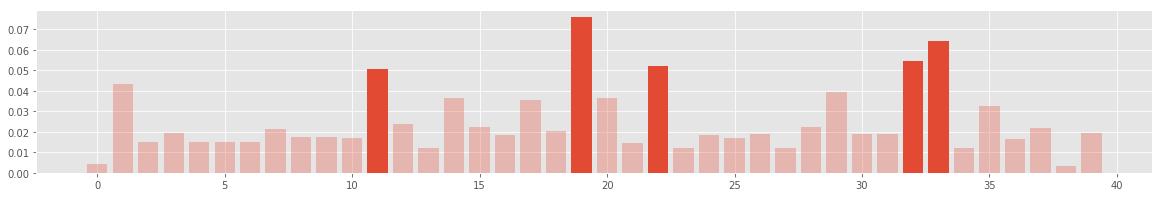

In [52]:
fig, ax = plt.subplots(figsize=(20,3))
ax.bar(range(K), topic_by_doc, alpha=0.3)
rects = ax.patches
for i in np.argsort(topic_by_doc)[-5:]:
    rects[i].set_alpha(1)

Here it becomes clear that the topic words should be fetched using some easier method

In [53]:
import collections

In [54]:
def get_topic_words(docs, n_words=10):
    topics_dict = {}
    for i in range(hdp.num_states):
        topics_dict[i] = collections.defaultdict(float)
    for i, doc in enumerate(temp_words):
        hdp.add_data(np.atleast_2d(docs[i][0].squeeze()), i)
        hdp.states_list[-1].meanfieldupdate()
        temp_exp = hdp.states_list[-1].all_expected_stats[0]
        for idx, word_id in enumerate(doc):
            for t in range(K):
                topics_dict[t][word_id] += temp_exp[idx, t]
    sorted_topic_words = []
    for t in range(K):
        sorted_topic_words.append([dictionary[k] for k in sorted(topics_dict[t], key=lambda x: topics_dict[t][x], reverse=True)[:n_words]])

    return np.array(sorted_topic_words)

In [55]:
words_numpy = get_topic_words(real_data)

In [56]:
import pandas as pd

In [57]:
word_df = pd.DataFrame(words_numpy.T)

In [58]:
word_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,data,university,processing,et,processing,processing,neural,information,et,et,...,information,et,abstract,different,processing,research,processing,information,figure,et
1,model,press,computation,al,computation,computation,systems,space,al,al,...,non,al,computational,based,analysis,references,et,space,right,al
2,parameters,mit,technical,ii,technical,technical,theory,shows,supported,center,...,space,ii,statistics,new,computation,edu,al,optimal,left,supported
3,models,science,current,ai,current,current,machine,optimal,appear,ii,...,components,ai,computing,learning,information,institute,computation,shows,fig,consists
4,example,cambridge,et,consists,et,recognition,ieee,fixed,technical,consists,...,higher,consists,implementation,use,multiple,ac,supported,fixed,plot,ai
5,set,pages,appear,supported,appear,appear,proceedings,mean,consists,current,...,experiments,center,estimation,simple,low,technology,technical,mean,panel,ii
6,usually,ma,al,center,al,et,journal,matrix,computation,ai,...,high,supported,paper,general,recognition,thank,appear,matrix,plots,center
7,network,department,recognition,similarly,recognition,al,nature,non,provided,similarly,...,shows,similarly,optimization,similar,control,com,consists,independent,corresponding,appear
8,observations,conference,supported,provided,supported,supported,visual,independent,processing,long,...,fixed,current,analysis,introduction,spatial,tr,current,non,table,provided
9,distribution,york,consists,appear,consists,consists,applications,small,center,supported,...,dimensional,long,efficient,statistical,current,http,provided,small,figures,similarly


### Next steps

Now that the functionality of the sHDP is a bit more clear the following steps should be made for easier handling:

1. Model to a simple Python class
2. Model to have similar interface to other topic models
3. More testing with larger datasets
4. Compare to the LDA
5. Verify the coherence PMI scores.